# Code to generate figure 2 in the publication
Analysis of sensitive enzymes and reactions in the model simulations

In [5]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import os
import sys

import numpy as np
from PIL import Image

from PAModelpy.configuration import Config
from PAModelpy.EnzymeSectors import ActiveEnzymeSector, UnusedEnzymeSector, TransEnzymeSector, CustomSector

sys.path.append('../Scripts/')
from pam_generation import set_up_ecoli_pam

BIOMASS_RXNID = Config.BIOMASS_REACTION
DATA_DIR = os.path.join(os.path.split(os.getcwd())[0], 'Data')
PAM_DATA_FILE_PATH = os.path.join(DATA_DIR, 'proteinAllocationModel_iML1515_EnzymaticData_py.xls')
glc_uptake_rates = list(np.linspace(0.5, 10, 20))

## sensitivities of GECKO and PAM

### 1 Usefull functions

In [16]:
def calculate_sensitivities(pamodel):
    glc_uptake_rates = np.linspace(0.5, 10, 20)
    Ccsc = []
    Cesc = []
    y_axis = []
    fluxes = []
    
    # disable pyruvate formate lyase (inhibited by oxygen)
    pamodel.change_reaction_bounds(rxn_id = 'PFL', upper_bound = 0)
    
    for glc in glc_uptake_rates:
        print('glucose uptake rate ', glc, ' mmol/gcdw/h')
        with pamodel:
            # change glucose uptake rate
            pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                            lower_bound = -glc, upper_bound = -glc)
            # solve the model
            sol_pam = pamodel.optimize()
            fluxes.append(sol_pam.fluxes)
            if pamodel.solver.status == 'optimal': y_axis += [glc]
            # save data
            Ccsc_new = list()
            
            if pamodel.solver.status == 'optimal':
                capacity_coeff = pamodel.capacity_sensitivity_coefficients
                for csc in ['flux_ub', 'flux_lb', 'enzyme_max','enzyme_min','proteome', 'sector']:
                    Ccsc_new += capacity_coeff[capacity_coeff['constraint'] == csc].coefficient.to_list()
                
                Ccsc += [Ccsc_new]

                enzyme_coeff = pamodel.enzyme_sensitivity_coefficients
                Cesc += [enzyme_coeff.coefficient.to_list()]
                
                print('Sum of capacity sensitivity coefficients: \t \t \t \t \t \t', round(sum(Ccsc_new),6))
                print('Sum of enzyme sensitivity coefficients: \t \t \t \t \t \t', round(sum(Cesc[-1]),6),'\n')

    return {'Ccsc':Ccsc, 'Cesc':Cesc, 'y_axis':y_axis, 'fluxes':fluxes, 'capacity coefficients':capacity_coeff, 'enzyme coefficients':enzyme_coeff}
            

In [7]:
def parse_x_axis_heatmap(capacity_coeff, enzyme_coeff):
    x_axis_csc = []
    
    for csc in ['flux_ub', 'flux_lb', 'enzyme_max','enzyme_min','proteome', 'sector']:
        if csc == 'flux_ub' or csc == 'flux_lb':
            x_axis_csc += [coef+'_'+ csc for coef in capacity_coeff[capacity_coeff['constraint'] == csc].rxn_id.to_list()]
        else:
            x_axis_csc += [coef+'_'+ csc for coef in capacity_coeff[
            capacity_coeff['constraint'] == csc].enzyme_id.to_list()]
    
    x_axis_esc = enzyme_coeff.enzyme_id.to_list()
    return x_axis_csc, x_axis_esc

In [8]:
def make_heatmap_subfigure(results, csc_matrix, esc_matrix, x_csc, x_esc, yaxis, fig, grdspc, ylabels = True, cbar =True, title=None,
                           fontsize = 16, vmin = -1.5, vmax = 1.5, annotate = None, phenotype_data = None, cmap = plt.cm.get_cmap('viridis')
):
    # fig = plt.figure()

    if cbar:
        gs = gridspec.GridSpecFromSubplotSpec(3, 2, width_ratios=[len(yaxis), 1], 
                                            height_ratios=[1,len(x_csc), len(x_esc)], hspace =0,
                                              subplot_spec=grdspc)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(3, 1, width_ratios=[len(yaxis)], 
                                            height_ratios=[1,len(x_csc), len(x_esc)], hspace =0,
                                              subplot_spec=grdspc)

    
    esc_ax = fig.add_subplot(gs[2,0]) #ESC heatmap
    acetate_ax = fig.add_subplot(gs[0,0]) #acetate production
    csc_ax = fig.add_subplot(gs[1,0],sharex = esc_ax) #CSC heatmap
    if cbar:
        cbar_ax = fig.add_subplot(gs[1:,1]) #colorbar

    #add annotation for subfigure (A or B)
    if annotate is not None:
        acetate_ax.annotate(annotate, xy=(2, 1), xycoords='data',
            xytext=(-0.05,1.5), textcoords='axes fraction',
            va='top', ha='left', fontsize = fontsize+5, weight = 'bold')

    glc_fluxes = [-sim.EX_glc__D_e for sim in results['fluxes']]
    
    #add arrow indicating growth regime
    #1. Find the start of the overflow regime (which is when acetate is being produced)
    for i,ac in enumerate([sim.EX_ac_e for sim in results['fluxes']]):
        if ac >0.01:
            glc_onset = glc_fluxes[i]
            break
    #2. determine the dx covered by respiration
    dx_respiration =  glc_onset-glc_fluxes[0]
    #3 create respiration arrow
    #forward arrow
    acetate_ax.arrow(
            glc_fluxes[0], 11, dx_respiration, 0,
        linewidth = 2, color = 'purple', label = 'Respiration', length_includes_head = True, head_width = 3, head_length = 0.5
    )
    #reverse arrow
    acetate_ax.arrow(
            glc_onset, 11, -dx_respiration, 0, head_starts_at_zero = True,
        linewidth = 2, color = 'purple', label = 'Respiration', length_includes_head = True, head_width = 3, head_length = 0.5
    )
    #annotate
    acetate_ax.annotate('Respiration',
                       xy=(dx_respiration/2, 15),
                         xytext=(10, -10), fontsize = fontsize,
                         textcoords='offset points', color = 'purple')
    #4. create overflow arrow
    #forward arrow
    acetate_ax.arrow(
        glc_onset, 11, 10-glc_onset,0,
        linewidth = 2, color = 'black', label = 'Overflow', length_includes_head = True,head_width = 3, head_length = 0.5
    )
    #reverse arrow
    acetate_ax.arrow(
        10, 11, -(10-glc_onset),0,
        linewidth = 2, color = 'black', label = 'Overflow', length_includes_head = True,head_width = 3, head_length = 0.5
    )
    #annotate
    acetate_ax.annotate('Overflow',fontsize = fontsize,
                       xy=((10-glc_onset)/2+glc_onset, 15),
                         xytext=(10, -10),
                         textcoords='offset points', color = 'black')
    
    #acetate graph
    acetate_ax.plot([-sim.EX_glc__D_e for sim in results['fluxes']], [sim.EX_ac_e for sim in results['fluxes']], 
                    linewidth = 4, color = 'darkblue')
    acetate_ax.tick_params(axis='y', labelsize=fontsize)
    acetate_ax.set_xlim([0, 10.5])
    acetate_ax.set_ylim([-0.5, 15])
    acetate_ax.xaxis.set_visible(False)
    if ylabels:
        acetate_ax.set_ylabel(r'Acetate' '\n' '[$mmol_{ac}/g_{CDW}/h$]',fontsize =fontsize, rotation = 0)

    #add phenotype data if this is given
    if phenotype_data is not None:
        acetate_ax.scatter(phenotype_data['EX_glc__D_e'], phenotype_data['EX_ac_e'],
                   color='purple', marker='o', s=40, linewidths=1.3,
                   facecolors=None, zorder=0,
                   label='Data')

    if title is not None: acetate_ax.set_title(title, fontsize = fontsize*1.5)
    
    #CAC heatmap
    im_csc = csc_ax.imshow(csc_matrix, aspect="auto", vmin = vmin, vmax =vmax, cmap = cmap)
    csc_ax.set_yticks(np.arange(len(x_csc)), labels=x_csc, fontsize =fontsize)
    csc_ax.xaxis.set_visible(False)
    if ylabels:
        csc_ax.set_ylabel('CSC', fontsize = fontsize)

    #Make line between CSC and ESC data more clear
    axis = 'bottom'
    csc_ax.spines[axis].set_linewidth(10)
    csc_ax.spines[axis].set_color("black")
    csc_ax.spines[axis].set_zorder(0)
    
    #ESC heatmap
    im_esc = esc_ax.imshow(esc_matrix, aspect="auto", vmin = vmin, vmax =vmax, cmap = cmap)
    esc_ax.set_yticks(np.arange(len(x_esc)), labels=x_esc, fontsize =fontsize)
    esc_ax.set_xticks(np.arange(len(yaxis)),labels = yaxis, fontsize =fontsize, rotation=45, ha='right')
    if ylabels:
        esc_ax.set_ylabel('ESC', fontsize = fontsize)
        
    #colorbar
    if cbar:
        cbar_ax.xaxis.set_visible(False)
        # cbar_ax.yaxis.set_visible(False)
        make_scaled_colorbar(ax=cbar_ax, vmin=vmin, vmax=vmax, fig = fig, fontsize = fontsize*1.25, cmap = cmap)
    # fig.set_figwidth(24)
    # fig.set_figheight(7)
    # fig.align_labels()
    return fig

In [9]:
def make_scaled_colorbar(ax, fig, cmap="viridis", vmin =-1, vmax = 1, fontsize = 16, cbarlabel = 'Sensitivity Coefficient'):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm = norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax =ax, cax=ax, shrink = 1, fraction = 1)
    #setting the fontsize of the colourbar
    cbar.set_label(cbarlabel,fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.yaxis.get_offset_text().set(size=fontsize)

In [10]:
#adjust labels for better readibility
def adjust_heatmap_labels(labels):
    new_labels = labels.copy()

    for i, label in enumerate(labels):
        if label =='EX_glc__D_e' or label[:-3] == 'EX_glc__D_e':
            if label[-1] == 'B': new_labels[i] = 'EX_glc_'+label[-2:]
            else: new_labels[i] = 'EX_glc'
        if label == 'TotalProteinConstraint_proteome':
            new_labels[i] = 'Protein pool'
        if label[0].isdigit(): #all enzyme ids start with a digit
            rxn_ids = pamodel.get_reactions_with_enzyme_id(label)
            rxn_name = pamodel.reactions.get_by_id(rxn_ids[-1]).name.split('(')[0]
            new_labels[i] = '\n'.join([part for part in rxn_name.split(' ')])
            
            # if len(rxn_ids)>2:
            #     new_labels[i] = pamodel.reactions.get_by_id(rxn_ids[-1]).name.split('(')[0]
            # else:
                
            #     new_labels[i] = ',\n'.join([pamodel.reactions.get_by_id(rxn_ids[-1]).name.split('(')[0]for rxn in rxn_ids])
    return new_labels

In [11]:
def find_nonzero_sensitivities(Cv, x_axis):
    indices = []
    for row in Cv:
        for index, coeff in enumerate(row):
            if abs(coeff)>0 and index not in indices:
                indices.append(index)
    
    coeff_nonzero = []
    for row in Cv:
        coeff_nonzero.append([coeff for i, coeff in enumerate(row) if i in indices])
    x_coeff_nonzero = [coeff for i, coeff in enumerate(x_axis) if i in indices]

    return coeff_nonzero, x_coeff_nonzero

In [28]:
def find_top5_sensitivities(Cv, x_axis, yaxis, threshold = 0.05):
    #top 5 enzymes per simulation
    Cv_df = pd.DataFrame(Cv, columns = x_axis, index =yaxis)
    largest = list()
    for i, row in Cv_df.iterrows():
        top5 = abs(row).nlargest()        
        if top5.iloc[0]:
            largest += [index for index, value in top5.items() if abs(value)>threshold]
    
    #remove duplicates
    largest_list = list(set(largest))

    #extract non duplicate top5 enzymes
    top5_df = Cv_df[largest_list].T.drop_duplicates().sort_index()
    largest_list = top5_df.index.values

    top5_matrix = [list(row) for i, row in top5_df.iterrows()]
    return top5_matrix, largest_list


### 2 Run GECKO simulations
#### 2.1 Adjust the total protein constraint for the lack of translational and unused protein

In [13]:
#calculate average protein which is allocated to sectors (5 mmol_glc/gdw/h and growth rate of 0.35)
translational_info = pd.read_excel(PAM_DATA_FILE_PATH , sheet_name='Translational')
unused_protein_info = pd.read_excel(PAM_DATA_FILE_PATH, sheet_name = 'ExcessEnzymes')

#protein allocated to unused enzymes
ups_0 = unused_protein_info[unused_protein_info.Parameter == 'ups_0'].loc[2, 'Value']
smax = unused_protein_info[unused_protein_info.Parameter == 's_max_uptake'].loc[1, 'Value']
ups_mu = ups_0 / smax

ups = ups_0 - (5*ups_mu)

#protein allocated to translational enzymes
tps_0=translational_info[translational_info.Parameter == 'tps_0'].loc[1,'Value']
tps_mu=translational_info[translational_info.Parameter == 'tps_mu'].loc[2,'Value']

tps = tps_0 + (0.35*tps_mu)

#total protein left for the active enzyme sector
total_protein = 0.258 - tps - ups

print(total_protein,' g_p/g_cdw/h')

0.11123186965376783  g_p/g_cdw/h


#### 2.2 Build GECKO model

In [14]:
# build the GECKO model with PAModelpy
pamodel_gecko = set_up_ecoli_pam(unused_enzymes = False, translational_enzymes = False, total_protein =total_protein)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-07
Read LP format model from file /tmp/tmp5yezjfgj.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.11123186965376783 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Done with setting up the proteome allocation model iML1515



#### 2.3 Run simulations for glucose uptake of 0-10 mmol/gcdw/h

In [17]:
results_gecko = calculate_sensitivities(pamodel_gecko)
x_axis_csc_gecko,x_axis_esc_gecko = parse_x_axis_heatmap(results_gecko['capacity coefficients'], results_gecko['enzyme coefficients'])

glucose uptake rate  0.5  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.0 

glucose uptake rate  1.0  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.0 

glucose uptake rate  1.5  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.000057
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.017221 

glucose uptake rate  2.0  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.000122
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.058797 

glucose uptake rate  2.5  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.000099
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.047689 

glucose uptake rate  3.0  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.000084
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.040353 

glucose uptake rate  3.5  mmol/gcdw/

In [18]:
#get all nonzero sensitivities
csc_nonzero_gecko, x_csc_nonzero_gecko = find_nonzero_sensitivities(results_gecko['Ccsc'], x_axis = x_axis_csc_gecko)
esc_nonzero_gecko, x_esc_nonzero_gecko = find_nonzero_sensitivities(results_gecko['Cesc'], x_axis = x_axis_esc_gecko)

In [19]:
csc_nonzero_gecko_t = np.transpose(np.array(csc_nonzero_gecko))
esc_nonzero_gecko_t = np.transpose(np.array(esc_nonzero_gecko))

In [41]:
#get top 5 nonzero sensitivities
csc_top5_gecko, x_csc_top5_gecko = find_top5_sensitivities(results_gecko['Ccsc'], x_axis = x_axis_csc_gecko, yaxis = glc_uptake_rates)
esc_top5_gecko, x_esc_top5_gecko = find_top5_sensitivities(results_gecko['Cesc'], x_axis = x_axis_esc_gecko, yaxis = glc_uptake_rates)
csc_top5_gecko_t = np.transpose(np.array(csc_top5_gecko))
esc_top5_gecko_t = np.transpose(np.array(esc_top5_gecko))

### 3 Run PAM simulations
#### 3.1 Build PAModel

In [21]:
pamodel = set_up_ecoli_pam()

Read LP format model from file /tmp/tmpsvi82yt5.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: 

Done with setting up the proteome allocation model iML1515



#### 3.2 Run simulations for glucose uptake of 0-10 mmol/gcdw/h

In [22]:
results_pam = calculate_sensitivities(pamodel)
x_axis_csc_pam,x_axis_esc_pam = parse_x_axis_heatmap(results_pam['capacity coefficients'], results_pam['enzyme coefficients'])

glucose uptake rate  0.5  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.213261 

glucose uptake rate  1.0  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.075763 

glucose uptake rate  1.5  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.051637 

glucose uptake rate  2.0  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.04222 

glucose uptake rate  2.5  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.0
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.116557 

glucose uptake rate  3.0  mmol/gcdw/h
Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 1.000176
Sum of enzyme sensitivity coefficients: 	 	 	 	 	 	 0.116705 

glucose uptake rate  3.5  mmol/gcdw/h
Sum 

In [23]:
#get nonzero sensitivities
csc_nonzero_pam, x_csc_nonzero_pam = find_nonzero_sensitivities(results_pam['Ccsc'], x_axis = x_axis_csc_pam)
esc_nonzero_pam, x_esc_nonzero_pam = find_nonzero_sensitivities(results_pam['Cesc'], x_axis = x_axis_esc_pam)
csc_nonzero_pam_t = np.transpose(np.array(csc_nonzero_pam))
esc_nonzero_pam_t = np.transpose(np.array(esc_nonzero_pam))

In [40]:
#get top5 nonzero sensitivities
csc_top5_pam, x_csc_top5_pam = find_top5_sensitivities(results_pam['Ccsc'], x_axis = x_axis_csc_pam, yaxis = glc_uptake_rates)
esc_top5_pam, x_esc_top5_pam = find_top5_sensitivities(results_pam['Cesc'], x_axis = x_axis_esc_pam, yaxis = glc_uptake_rates)
csc_top5_pam_t = np.transpose(np.array(csc_top5_pam))
esc_top5_pam_t = np.transpose(np.array(esc_top5_pam))

### 4 Create plot

#### 4.1 Load phenotypic data

In [24]:
# load phenotype data from excel file
pt_data = pd.read_excel(os.path.join(DATA_DIR, 'Ecoli_phenotypes','Ecoli_phenotypes_py_rev.xls'), sheet_name='Yields', index_col=None)
pt_data['EX_glc__D_e'] = -pt_data['EX_glc__D_e']

### 4.2 Load manually created plot with mapped sensitivities

In [26]:
image_path = 'Figure2_mapped_sensitivities.png'

sensitivities_mapped =np.asarray(Image.open(image_path))

/tmp/ipykernel_13254/2282188962.py:53: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.3)


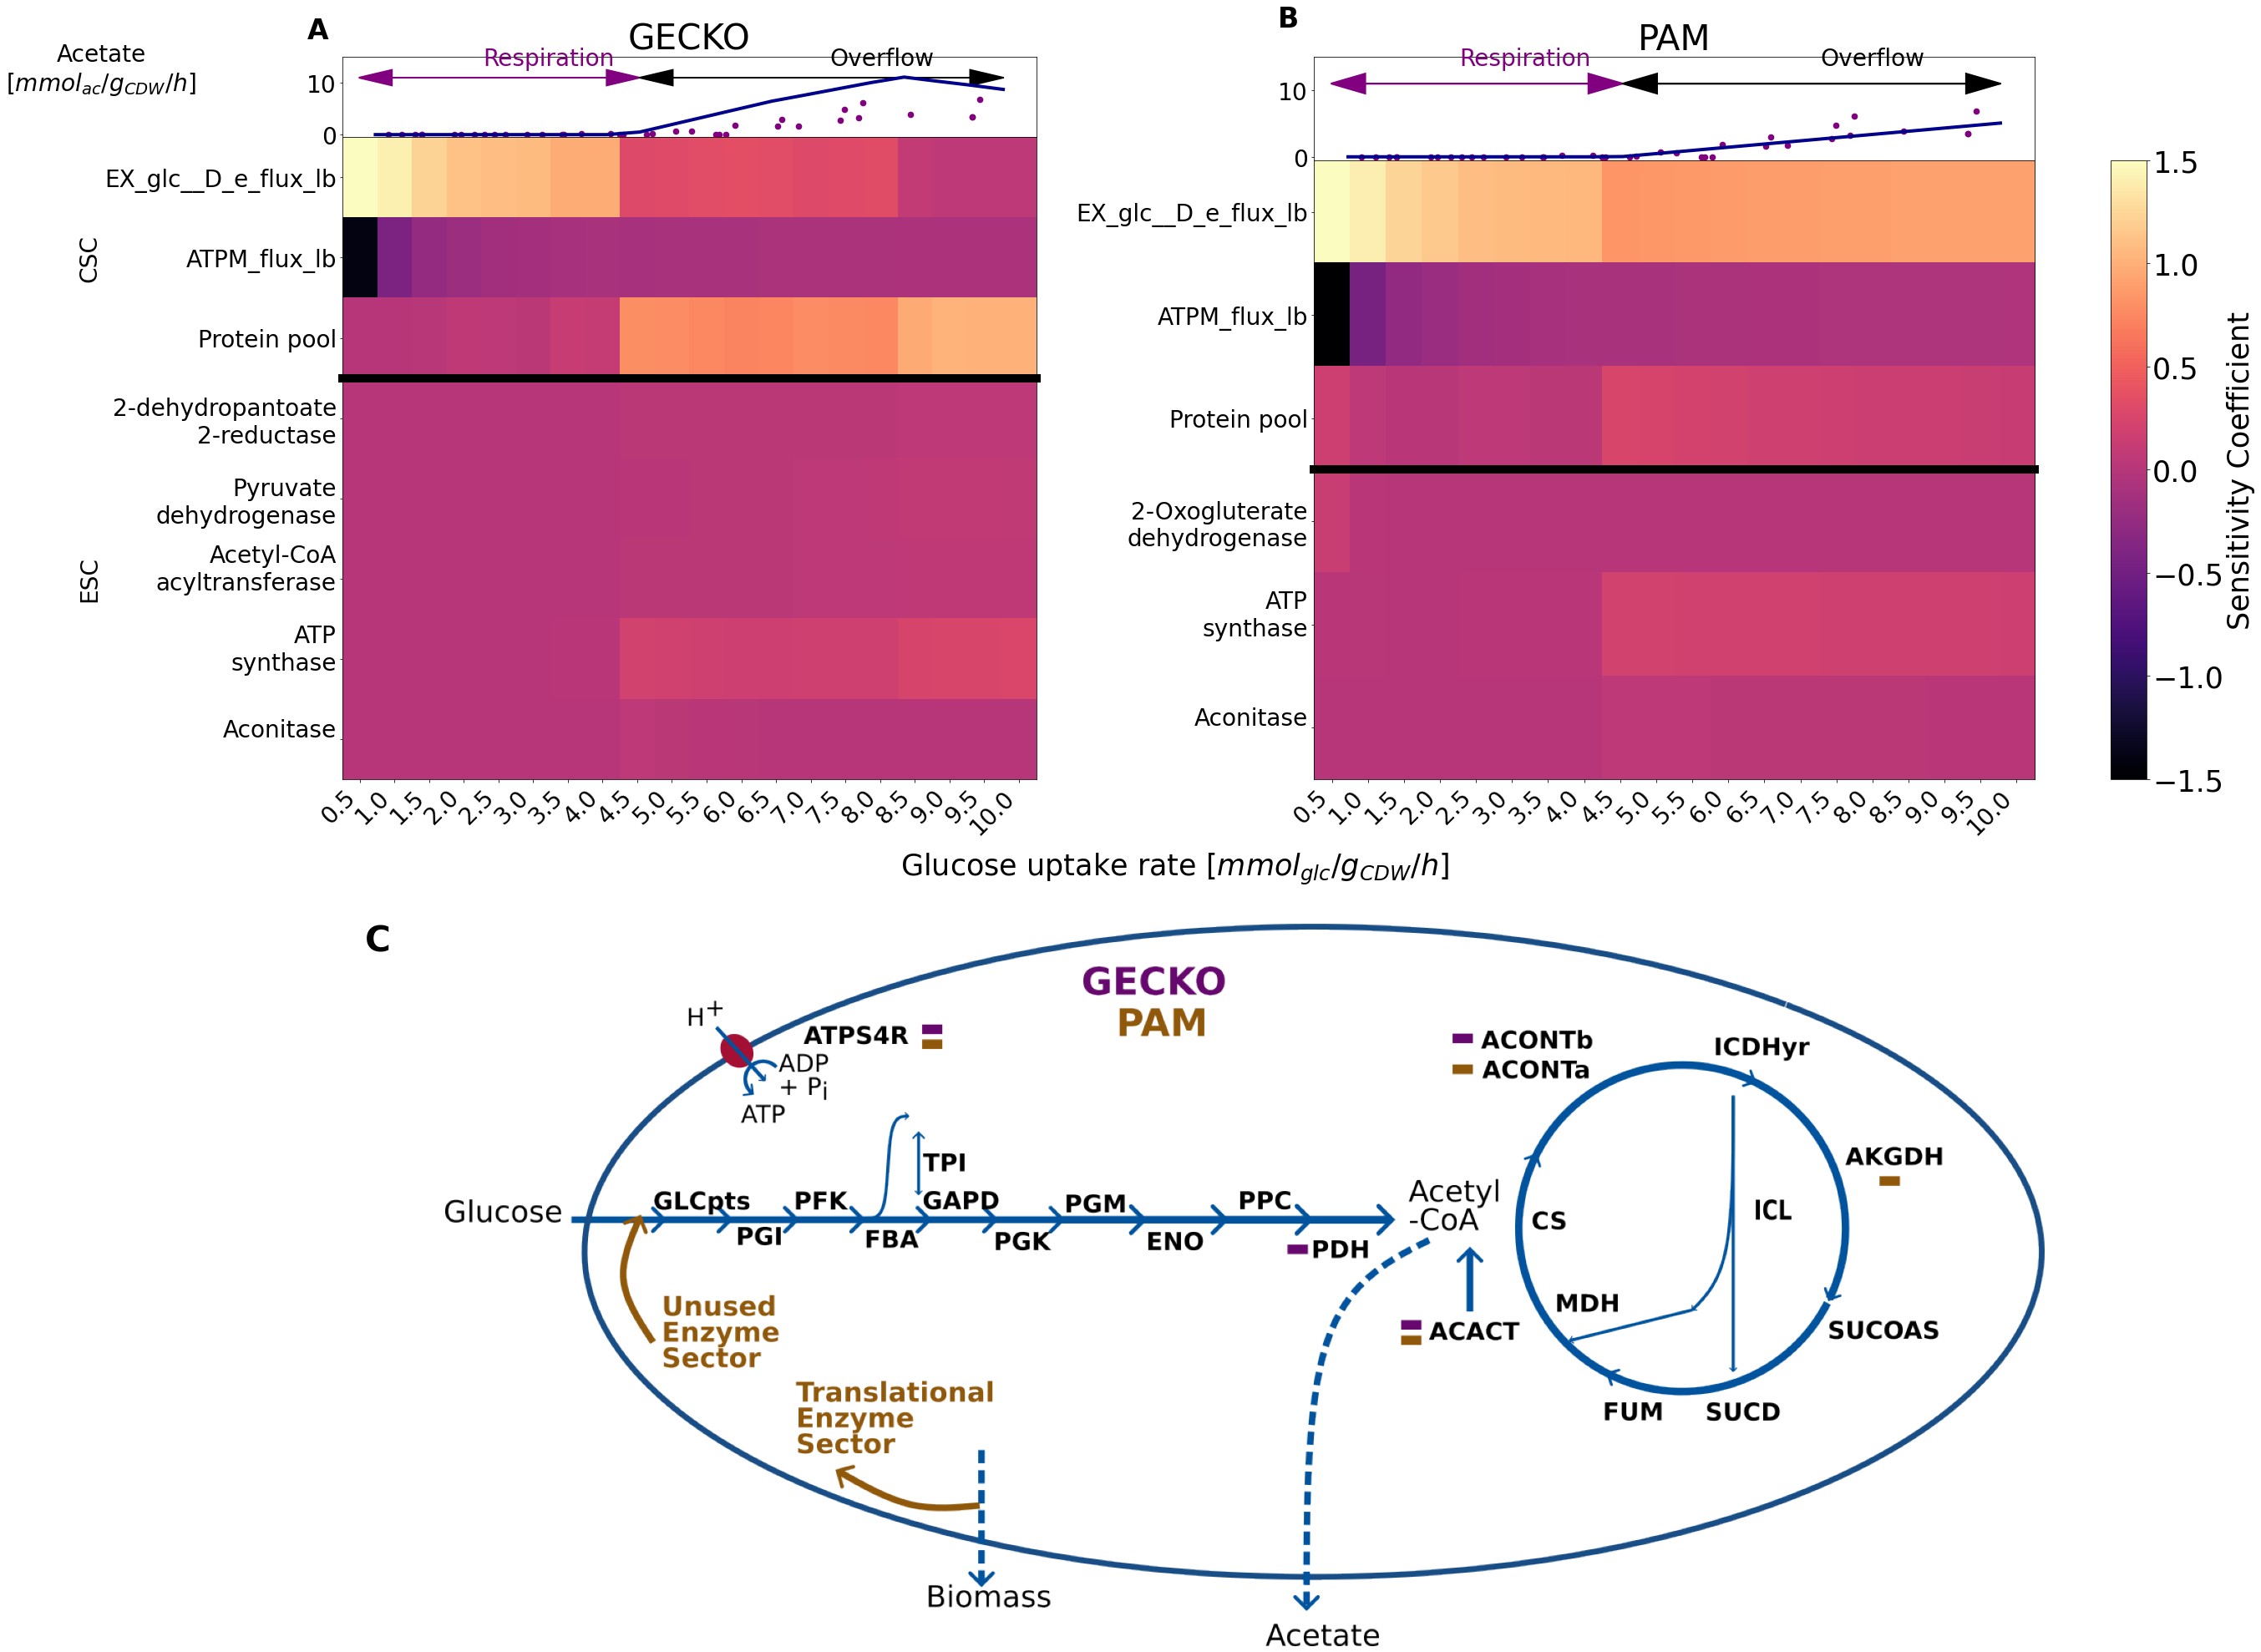

In [42]:
#create 1 big plot
fontsize = 28
width = 50
height = 35
# select colormap
cmap = plt.cm.get_cmap('magma')

# gridspec inside gridspec
fig = plt.figure(layout = 'constrained')


gs0 = gridspec.GridSpec(2, 14, figure=fig, wspace = 10000)
gs_gecko = gs0[0,:6]
gs_pam = gs0[0,7:]
gs_figure = gs0[1,:]

#adjust labels for better readibility
x_csc_label_gecko = adjust_heatmap_labels(x_csc_nonzero_gecko)
x_esc_label_gecko = adjust_heatmap_labels(x_esc_top5_gecko)

fig_gecko = make_heatmap_subfigure(results = results_gecko, csc_matrix=csc_nonzero_gecko_t, esc_matrix =esc_top5_gecko,cbar =False,
                                   x_csc=x_csc_label_gecko, x_esc=x_esc_label_gecko, yaxis = glc_uptake_rates, fig = fig, grdspc = gs_gecko,
                                   annotate = 'A',phenotype_data = pt_data, fontsize = fontsize, cmap=cmap, title = 'GECKO')
# fig_gecko.subplots_adjust(left=0.3)
#adjust labels for better readibility
x_csc_label_pam = adjust_heatmap_labels(x_csc_nonzero_pam)
x_esc_label_pam = adjust_heatmap_labels(x_esc_top5_pam)

fig_pam = make_heatmap_subfigure(results = results_pam, csc_matrix=csc_nonzero_pam_t, esc_matrix =esc_top5_pam, ylabels = False,
                                   x_csc=x_csc_label_pam, x_esc=x_esc_label_pam, yaxis = glc_uptake_rates, fig = fig, grdspc=gs_pam, 
                                 annotate = 'B', phenotype_data = pt_data, fontsize = fontsize, cmap = cmap, title = 'PAM')

#set common x axis title
ax_xlabel = fig.add_subplot(gs0[0, :2])
ax_xlabel.set_xticks([])
ax_xlabel.set_yticks([])
ax_xlabel.set_frame_on(False)
ax_xlabel.set_xlabel('Glucose uptake rate [$mmol_{glc}/g_{CDW}/h$]', fontsize = fontsize*1.25)
ax_xlabel.xaxis.set_label_coords(6, -.1)

#add image

ax_fig = fig.add_subplot(gs_figure)
ax_fig.imshow(sensitivities_mapped)
ax_fig.annotate('C', xy=(2, 1), xycoords='data',
            xytext=(-0.05,1), textcoords='axes fraction',
            va='top', ha='left', fontsize = fontsize*1.5, weight = 'bold')
ax_fig.axis('off')
ax_fig.set_xticks([])
ax_fig.set_yticks([])

plt.plasma()
fig.subplots_adjust(left=0.3)
fig.set_figwidth(width)
fig.set_figheight(height)
fig.align_labels()

fig.savefig('Figure2_sensitivities_gecko_pam.png', dpi =200,bbox_inches='tight')